## 음성부분 수정된 버전1.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at kresnik/wav2vec2-large-xlsr-korean and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-4b2078dd7d82>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

Saving 너무-힘들어.wav to 너무-힘들어.wav

Processing file: 너무-힘들어.wav
Transcription: 아 너무 힘들어
Combined Emotion Analysis Result (Logits): tensor([[ 0.1501, -0.4400,  0.6027, -0.3414, -0.1387,  0.0649, -0.0787, -0.1086,
         -0.2813,  1.6240, -0.9741, -0.4977,  0.1187, -0.2199]],
       grad_fn=<CatBackward0>)
Audio Probabilities: tensor([0.1613, 0.0894, 0.2536, 0.0986, 0.1208, 0.1481, 0.1283],
       grad_fn=<SoftmaxBackward0>)
Text Probabilities: tensor([0.0931, 0.0783, 0.5263, 0.0392, 0.0631, 0.1168, 0.0833],
       grad_fn=<SoftmaxBackward0>)
Final Probabilities: tensor([0.0999, 0.0794, 0.4990, 0.0451, 0.0688, 0.1199, 0.0878],
       grad_fn=<AddBackward0>)
Predicted Emotion: sad


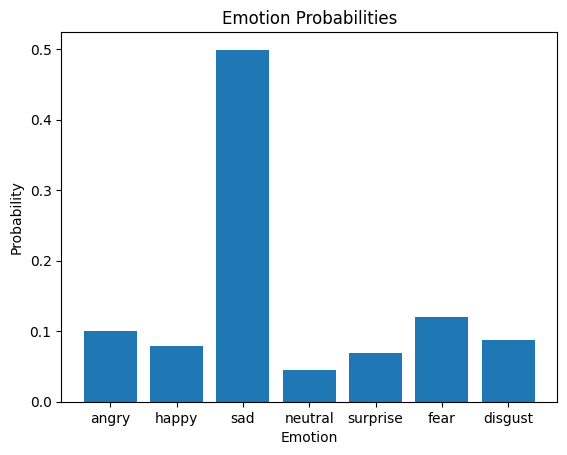

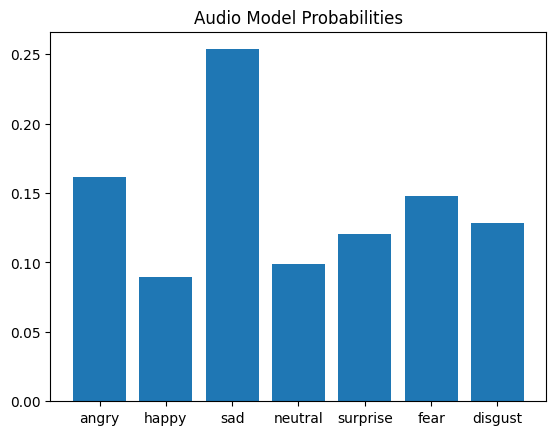

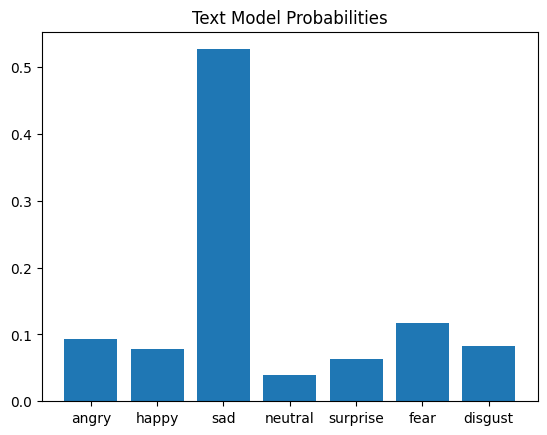

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "STT.json"  # Google STT 인증 키 설정 및 파일 이름 수정

from google.colab import drive
drive.mount('/content/drive')

audio_model_path = '/content/drive/MyDrive/음성파일/수정음성_model.pt'
text_model_path = '/content/drive/MyDrive/TextModel/Text_model.pth'

import torch
from transformers import AutoTokenizer, Wav2Vec2ForSequenceClassification, AutoModelForSequenceClassification
import torchaudio

# Wav2Vec2 모델 초기화
audio_model = Wav2Vec2ForSequenceClassification.from_pretrained("kresnik/wav2vec2-large-xlsr-korean", num_labels=7)

# `classifier` 레이어의 입력 크기를 `projector` 출력 크기(256)에 맞게 수정
audio_model.classifier = torch.nn.Linear(256, 7)  # projector의 출력 크기 256에 맞춤

# 저장된 모델 가중치 로드
pretrained_state_dict = torch.load(audio_model_path, map_location=torch.device('cpu'))

# `classifier` 레이어를 제외한 나머지 가중치 로드
pretrained_state_dict = {k: v for k, v in pretrained_state_dict.items() if not k.startswith("classifier")}
audio_model.load_state_dict(pretrained_state_dict, strict=False)

# `classifier`는 새로 초기화된 상태로 사용
audio_model.eval()

# KcELECTRA 모델 초기화
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
class KcELECTRAWithDropout(torch.nn.Module):
    def __init__(self):
        super(KcELECTRAWithDropout, self).__init__()
        self.electra = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=7)
        self.dropout = torch.nn.Dropout(p=0.6)
        self.batch_norm = torch.nn.BatchNorm1d(7)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)
        return self.batch_norm(logits)

text_model = KcELECTRAWithDropout()
text_model.load_state_dict(torch.load(text_model_path, map_location=torch.device('cpu')))
text_model.eval()

# STT로 텍스트 변환
from google.cloud import speech
from pydub import AudioSegment

def transcribe_audio(audio_path):
    sound = AudioSegment.from_wav(audio_path)
    sound = sound.set_channels(1)
    mono_audio_path = "mono_audio_file.wav"
    sound.export(mono_audio_path, format="wav")

    client = speech.SpeechClient()
    with open(mono_audio_path, "rb") as audio_file:
        content = audio_file.read()
    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        language_code="ko-KR",
    )
    response = client.recognize(config=config, audio=audio)

    for result in response.results:
        return result.alternatives[0].transcript

# 음성 데이터를 로드하고 모델에 맞게 전처리하는 함수
def preprocess_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)  # 모노로 변환
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resample_transform(waveform)  # 16kHz로 리샘플링
    waveform = waveform.squeeze(0)  # Conv1d는 2D나 3D 텐서를 기대하므로 채널 차원을 제거
    return waveform.unsqueeze(0)  # 배치 차원 추가

# 멀티모달 분석 실행
def analyze_emotion(audio_path):
    # STT를 사용하여 텍스트로 변환
    transcript = transcribe_audio(audio_path)
    print(f"Transcription: {transcript}")

    # 음성 입력 처리
    audio_input = preprocess_audio(audio_path)
    audio_emotion = audio_model(audio_input).logits  # logits: [batch_size, num_labels]

    # 텍스트 입력 처리
    text_input = tokenizer(transcript, padding=True, truncation=True, return_tensors="pt")
    text_emotion = text_model(text_input["input_ids"], text_input["attention_mask"])

    # 음성과 텍스트 감정 결합
    combined_emotion = torch.cat((audio_emotion, text_emotion), dim=1)
    return combined_emotion

from google.colab import files

# 파일 업로드 또는 기존 파일 경로 설정
uploaded = files.upload()

# 업로드된 파일 처리
audio_path = None
for file_name in uploaded.keys():
    print(f"\nProcessing file: {file_name}")
    audio_path = f"/content/{file_name}"

if not audio_path:
    # 기본 파일 설정 (파일 경로를 직접 넣을 수 있음)
    audio_path = "/content/오늘-너무-재미있었어.wav"  # 필요한 파일 경로를 입력

# analyze_emotion 함수 실행
result = analyze_emotion(audio_path)
print("Combined Emotion Analysis Result (Logits):", result)

# 텐서에서 음성과 텍스트 출력 분리
audio_logits = result[0, :7]
text_logits = result[0, 7:]

# Softmax 적용하여 확률 계산
audio_probs = torch.softmax(audio_logits, dim=0)
text_probs = torch.softmax(text_logits, dim=0)

# 가중 평균 계산 (Weight 설정 가능)
weight_audio = 0.1  # 음성 모델 가중치
weight_text = 0.9   # 텍스트 모델 가중치
final_probs = weight_audio * audio_probs + weight_text * text_probs

# 감정 클래스 정의
emotion_labels = ["angry", "happy", "sad", "neutral", "surprise", "fear", "disgust"]

# 최종 감정 예측
predicted_emotion_idx = torch.argmax(final_probs).item()
predicted_emotion = emotion_labels[predicted_emotion_idx]

# 결과 출력
print("Audio Probabilities:", audio_probs)
print("Text Probabilities:", text_probs)
print("Final Probabilities:", final_probs)
print("Predicted Emotion:", predicted_emotion)

# 감정 분석 결과 시각화
import matplotlib.pyplot as plt

plt.bar(emotion_labels, final_probs.detach().numpy())
plt.title("Emotion Probabilities")
plt.xlabel("Emotion")
plt.ylabel("Probability")
plt.show()

# 음성 모델 확률 시각화
plt.bar(emotion_labels, audio_probs.detach().numpy())
plt.title("Audio Model Probabilities")
plt.show()

# 텍스트 모델 확률 시각화
plt.bar(emotion_labels, text_probs.detach().numpy())
plt.title("Text Model Probabilities")
plt.show()